<a href="https://colab.research.google.com/github/falseywinchnet/PyITD/blob/main/NewGPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
#copyright joshuah.rainstar@gmail.com 2025
#MIT with attribution

import math
import copy
from dataclasses import dataclass
from typing import Optional, Tuple, List

import torch
import torch.nn as nn
import torch.nn.functional as F

class RoPE(nn.Module):
    """Rotary Positional Embeddings."""
    def __init__(self, dim, max_len=4096):
        super().__init__()
        self.dim = dim
        inv_freq = 1.0 / (10000 ** (torch.arange(0, dim, 2).float() / dim))
        t = torch.arange(max_len).float()
        freqs = torch.einsum('i,j->ij', t, inv_freq)
        self.register_buffer('cos', freqs.cos())
        self.register_buffer('sin', freqs.sin())

    def forward(self, x):
        # x: (B, H, T, D)
        seq_len = x.shape[2]
        cos = self.cos[:seq_len, :].unsqueeze(0).unsqueeze(0)
        sin = self.sin[:seq_len, :].unsqueeze(0).unsqueeze(0)
        x1 = x[..., 0::2]
        x2 = x[..., 1::2]
        return torch.cat((-x2 * sin + x1 * cos, x1 * sin + x2 * cos), dim=-1)

class WedgeTransform(nn.Module):
    """Global Wedge (Symplectic Twist)."""
    def __init__(self, dim, heads):
        super().__init__()
        self.n_head = heads
        self.head_dim = dim // heads
        self.A = nn.Parameter(torch.zeros(heads, self.head_dim, self.head_dim))

    def forward(self, x):
        # x: (B, H, T, D)
        S = self.A - self.A.transpose(-1, -2)
        flow = torch.matmul(x, S)
        return x + flow

class ConvexSoftmax(nn.Module):
    """Convex LSE (Float32 Precision)."""
    def forward(self, scores):
        m, _ = scores.max(dim=-1, keepdim=True)
        y = scores - m
        ex = y.exp()
        lse = m + ex.sum(dim=-1, keepdim=True).log()
        return torch.exp(scores - lse)

class WedgeTransform(nn.Module):
    def __init__(self, dim, heads):
        super().__init__()
        self.head_dim = dim // heads
        self.A = nn.Parameter(torch.randn(heads, self.head_dim, self.head_dim) * 0.02)
    def forward(self, x):
        S = self.A - self.A.transpose(-1, -2)
        return x + torch.matmul(x, S)

def torch_eval_legendre(n, x):
    """
    PyTorch implementation of Legendre polynomials P_n(x).
    Valid for n in [0, 1, 2, 3].

    Args:
        n (int): Degree of the polynomial.
        x (torch.Tensor): Input tensor.
    Returns:
        torch.Tensor: P_n(x) with same shape as x.
    """
    if n == 0:
        return torch.ones_like(x)
    elif n == 1:
        return x
    elif n == 2:
        return 0.5 * (3 * x.pow(2) - 1)
    elif n == 3:
        return 0.5 * (5 * x.pow(3) - 3 * x)
    else:
        # Fallback recursion for n > 3 if ever needed
        # (n)P_n = (2n-1)x P_{n-1} - (n-1)P_{n-2}
        p_prev = 0.5 * (3 * x.pow(2) - 1) # P2
        p_curr = 0.5 * (5 * x.pow(3) - 3 * x) # P3
        for i in range(4, n + 1):
            p_next = ((2 * i - 1) * x * p_curr - (i - 1) * p_prev) / i
            p_prev, p_curr = p_curr, p_next
        return p_curr

class AlpertQueryGenerator(nn.Module):
    def __init__(self, in_channels, num_heads, head_dim, max_degree=None):
        super().__init__()
        self.C = in_channels
        self.H = num_heads
        self.Dh = head_dim

        assert in_channels % num_heads == 0, "C must be divisible by H"

        self.split_size = in_channels // num_heads
        # Default degree uses all available head dimensions
        self.degree = max_degree if max_degree is not None else head_dim

        # Build basis using pure Torch
        basis_matrix = self._build_basis(self.H, self.split_size, self.Dh)
        self.register_buffer('alpert_basis', basis_matrix)

        self.spectral_scale = nn.Parameter(torch.ones(1, self.H, 1, self.Dh))

    def _build_basis(self, num_intervals, interval_size, num_modes):
        # 1. Define domain nodes [-1, 1] using Torch
        # Use register_buffer logic implicitly by creating on CPU first,
        # it will move to device when the module moves.
        x = torch.linspace(-1, 1, steps=interval_size)

        # 2. Generate Legendre Polynomials
        modes = []
        for k in range(num_modes):
            # Normalization factor sqrt((2k+1)/2)
            norm_factor = math.sqrt((2 * k + 1) / 2)

            # Use local torch implementation
            poly = torch_eval_legendre(k, x) * norm_factor
            modes.append(poly)

        # Stack: (Split_Size, Dh)
        basis = torch.stack(modes, dim=1)

        # 3. Replicate for heads: (H, S, Dh)
        basis_full = basis.unsqueeze(0).expand(num_intervals, -1, -1)

        return basis_full

    def forward(self, x):
        B, T, C = x.shape

        # 1. Isolate Heads
        x_reshaped = x.view(B, T, self.H, self.split_size)

        # 2. Alpert Transform
        Q = torch.einsum('bths,hsd->bthd', x_reshaped, self.alpert_basis)

        # 3. Spectral Scaling
        Q = Q.permute(0, 2, 1, 3).contiguous()
        Q = Q * self.spectral_scale

        return Q # Returns Q now!

class Attention(nn.Module):
    def __init__(self, d_model, n_head, use_sink=True):
        super().__init__()
        self.d_model = d_model
        self.n_head = n_head
        self.head_dim = d_model // n_head
        self.use_sink = use_sink
        self.scale = self.head_dim ** -0.5

        # Projections
        self.W_Q = nn.Linear(d_model, d_model, bias=True)
        self.W_K = nn.Linear(d_model, d_model, bias=True)
        self.W_V = AlpertQueryGenerator(d_model, n_head, self.head_dim, max_degree=3)
        self.W_O = nn.Linear(d_model, d_model, bias=True)
        self.wedge = WedgeTransform(d_model, n_head)
        # Geometry/Stability components
        self.rope = RoPE(self.head_dim)
        self.softmax = ConvexSoftmax()

        if use_sink:
            self.sink_scalar = nn.Parameter(torch.zeros(1, n_head, 1, 1))
            self.v_null = nn.Parameter(torch.zeros(1, n_head, 1, self.head_dim))

    def forward(self, x):
        B, T, C = x.shape
        H, Dh = self.n_head, self.head_dim

        # 1. Projections
        q_raw = self.W_Q(x).view(B, T, H, Dh).transpose(1, 2) # Context Candidates
        k_raw = self.W_K(x).view(B, T, H, Dh).transpose(1, 2)
        v_val = self.W_V(x) # The Content (V)

        k_raw = self.wedge(k_raw)
        q_raw = self.wedge(q_raw)

        q_geo = self.rope(q_raw)
        k_geo = self.rope(k_raw)

        Attn = (q_geo @ k_geo.transpose(-2, -1)) * self.scale

        mask = torch.triu(torch.ones(T, T, device=x.device), diagonal=1).bool()
        Attn.masked_fill_(mask, float('-inf'))

        null_scores = self.sink_scalar.expand(B, H, T, 1)
        Attn_full = torch.cat([Attn, null_scores], dim=-1)
        probs_full = self.softmax(Attn_full)

        out = probs_full[..., :T] @ v_val + probs_full[..., T:] * self.v_null
        out = out.transpose(1, 2).contiguous().view(B, T, C)
        return self.W_O(out)


class LayerNorm(nn.Module):
    def __init__(self, ndim: int, bias: bool = True):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.use_bias = bias
        if bias:
            self.bias = nn.Parameter(torch.zeros(ndim))
        else:
            self.register_parameter("bias", None)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        b = self.bias if self.use_bias else None
        return F.layer_norm(x, self.weight.shape, self.weight, b, 1e-5)

class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear( config.n_embd,4* config.n_embd, bias=config.bias)
        self.scale = math.pi / math.sqrt(3.0)

        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = x * torch.sigmoid(self.scale * x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn = Attention(config.n_embd,config.n_head)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

import torch.utils.checkpoint as checkpoint # New: Required for activation checkpointing
@dataclass
class GPTConfig:
    block_size: int = 1024
    vocab_size: int = 50304 # GPT-2 vocab_size of 50257, padded up to nearest multiple of 64 for efficiency
    n_layer: int = 12
    n_head: int = 12
    n_embd: int = 768
    dropout: float = 0.0
    bias: bool = True # True: bias in Linears and LayerNorms, like GPT-2. False: a bit better and faster

class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = LayerNorm(config.n_embd, bias=config.bias),
        ))

        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        # report number of parameters
        print("number of parameters: %.2fM" % (self.get_num_params()/1e6,))

    def get_num_params(self, non_embedding=True):
        """
        Return the number of parameters in the model.
        For non-embedding count (default), the position embeddings get subtracted.
        The token embeddings would too, except due to the parameter sharing these
        params are actually used as weights in the final layer, so we include them.
        """
        n_params = sum(p.numel() for p in self.parameters())
        return n_params

    def forward(self, idx, targets=None):
        device = idx.device
        b, T = idx.size()

        # forward the GPT model itself
        x = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)

        for block in self.transformer.h:
            x = checkpoint.checkpoint(block, x, use_reentrant=False)

        x = self.transformer.ln_f(x)

        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)

            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)

        else:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None

        return logits, loss


In [2]:
import requests, os

base_url = "https://huggingface.co/datasets/cambridge-climb/BabyLM/resolve/main/clean/10M/"
target_dir = "./babylm_10m_cleaned"
os.makedirs(target_dir, exist_ok=True)

file_names = [
    "aochildes.txt",
    "cbt.txt",
    "children_stories.txt",
    "gutenberg.txt",
    "qed.txt",
    "simple_wikipedia.txt",
    "switchboard.txt",
    "wikipedia.txt"
]

# Optional addition: Shakespeare from another dataset
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/refs/heads/master/data/tinyshakespeare/input.txt"
shakespeare_fname = "shakespeare.txt"

# Combined download logic
all_files = [(base_url + fname, fname) for fname in file_names]
all_files.append((shakespeare_url, shakespeare_fname))  # Add Shakespeare


# Download loop
for url, fname in all_files:
    out_path = os.path.join(target_dir, fname)
    print(f"📥 Downloading {fname}...")
    resp = requests.get(url)
    if resp.status_code == 200:
        with open(out_path, "w", encoding="utf-8") as f:
            f.write(resp.text)
    else:
        print(f"❌ Failed to download {fname} ({resp.status_code})")

print(f"✅ Done. Files saved to {target_dir}")

📥 Downloading aochildes.txt...
📥 Downloading cbt.txt...
📥 Downloading children_stories.txt...
📥 Downloading gutenberg.txt...
📥 Downloading qed.txt...
📥 Downloading simple_wikipedia.txt...
📥 Downloading switchboard.txt...
📥 Downloading wikipedia.txt...
📥 Downloading shakespeare.txt...
✅ Done. Files saved to ./babylm_10m_cleaned


In [3]:
import os
import pickle
import numpy as np

# === Paths ===
source_dir = "./babylm_10m_cleaned"
out_dir    = "./babylm_char_tokenized"
os.makedirs(out_dir, exist_ok=True)

file_names = [
    "shakespeare.txt"#,#"aochildes.txt", "cbt.txt", "children_stories.txt", "gutenberg.txt",
    #"qed.txt", "simple_wikipedia.txt", "switchboard.txt", "wikipedia.txt"
]

# === Load and split ===
train_texts, val_texts = [], []
char_set = set()

for fname in file_names:
    with open(os.path.join(source_dir, fname), encoding="utf-8") as f:
        lines = f.readlines()
        n = len(lines)
        split = int(0.9 * n)
        train_part = "".join(lines[:split])
        val_part   = "".join(lines[split:])
        train_texts.append(train_part)
        val_texts.append(val_part)
        char_set.update(train_part)
        char_set.update(val_part)

full_train = "\n".join(train_texts)
full_val   = "\n".join(val_texts)

# === Final vocab ===
char_set = sorted(set(char_set))
vocab_chars = ["<unk>"] + [c for c in char_set if c != "<unk>"]

stoi = {ch: i for i, ch in enumerate(vocab_chars)}
itos = {i: ch for ch, i in stoi.items()}

# === Encode function ===
def encode(text):
    return [stoi.get(c, 0) for c in text]

train_ids = np.array(encode(full_train), dtype=np.uint16)
val_ids   = np.array(encode(full_val),   dtype=np.uint16)

# === Save ===
train_ids.tofile(os.path.join(out_dir, "train.bin"))
val_ids.tofile(os.path.join(out_dir, "val.bin"))

with open(os.path.join(out_dir, "meta.pkl"), "wb") as f:
    pickle.dump({
        "vocab_size": len(stoi),
        "stoi": stoi,
        "itos": itos
    }, f)

print(f"✅ Char tokenizer finalized.")
print(f"🧾 Train tokens: {len(train_ids)} | Val tokens: {len(val_ids)}")
print(f"🔤 Vocab size: {len(stoi)}")

✅ Char tokenizer finalized.
🧾 Train tokens: 1016242 | Val tokens: 99152
🔤 Vocab size: 66


In [19]:
# import os
import pickle
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torch
from torch import nn
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"

# === Config ===
data_dir = "./babylm_char_tokenized"  # <- char-tokenized data
block_size = 1024
batch_size = 16

# === Load tokenizer metadata ===
with open(os.path.join(data_dir, 'meta.pkl'), 'rb') as f:
    meta = pickle.load(f)
vocab_size = meta['vocab_size']

# === Load mmap edata (char-level tokens, uint16) ===
train_ids = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
val_ids   = np.memmap(os.path.join(data_dir, 'val.bin'),   dtype=np.uint16, mode='r')

# === Efficient GPU Batch Sampler ===
class GPUBatchDataset(Dataset):
    def __init__(self, mmap_file, block_size, batch_size, device, jitter=63, p_aligned=0.5, pad_len=0):
        self.data = mmap_file
        self.block_size = block_size
        self.batch_size = batch_size
        self.device = device
        self.pad_len = int(pad_len)
        self.sample_len = self.block_size + self.pad_len  # X length
        self.total = len(self.data) - self.sample_len - 1
        self.n_blocks = self.total // self.sample_len
        self.jitter = int(jitter)          # small random offset added to aligned start
        self.p_aligned = float(p_aligned)  # mix aligned and jittered

    def __len__(self):
        return self.total // self.batch_size

    def __getitem__(self, idx):
        X = np.empty((self.batch_size, self.sample_len), dtype=np.int64)
        Y = np.empty((self.batch_size, self.block_size), dtype=np.int64)

        for i in range(self.batch_size):
            # choose a base aligned block
            base_block = np.random.randint(0, self.n_blocks)
            start = base_block * self.sample_len

            # with probability, add a small jitter (keeps cache-friendly contiguous reads)
            if np.random.rand() > self.p_aligned:
                j = np.random.randint(0, self.jitter + 1)
                start = min(start + j, self.total)  # stay in range

            X[i] = self.data[start : start + self.sample_len]
            # targets correspond to the final block_size visible steps
            Y[i] = self.data[start + 1 + self.pad_len : start + 1 + self.pad_len + self.block_size]


        return (
            torch.from_numpy(X).to(self.device, non_blocking=True),
            torch.from_numpy(Y).to(self.device, non_blocking=True)
        )


config = GPTConfig(
    vocab_size=len(stoi),
    n_layer=6,
    n_embd=256,
    n_head = 4,
    block_size=block_size
)
train_dataset = GPUBatchDataset(train_ids, block_size, batch_size, device, pad_len=0)
# === DataLoader ===
train_loader  = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=0)
torch.set_float32_matmul_precision('high') #perf on A100
model = GPT(config)
model = torch.compile(model)
model = model.to(device)



number of parameters: 4.48M


```
11/27/25
joshs notes at 4 fucking am

next steps for design:
get per-head sink activation statistics
use to select expert- 1 per head- in moe of block
use hard routed or soft routed, prolly doesnt matter

The Q-star mechanism:
Replace CEloss with a system which collects markov/red/green continuations
takes targets and builds logit distributions of likely continuations
evolves over time to represent all possible forecasts at T in probability
and which uses a peaking student-t reshaping deeper into model
to condition the model to become a beam search system
ie model out-projects to logits using lm_head at each layer,
we take mismatch as aux loss, we accumulate aux and return as loss

softmax is garbage in terms of manifold deterministic intelligence, but then,
how do we make next choices? we need the next position target that represents
the models confidence as a distribution. here too q-star picks next step.
or something


```

In [20]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)
losses = []
def train_epoch():
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
          xb, yb = xb[0], yb[0]  # unwrap batch dimension
          optimizer.zero_grad()
          logits, loss = model(xb, yb)
          loss = loss
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
          optimizer.step()
          total_loss += loss.item()
          losses.append(loss.item())
          print(loss.item())
    return total_loss / len(train_loader)

# === Run Training ===
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch()
    print(f"Epoch {epoch:2d} | Train loss: {train_loss:.4f}")

4.378211975097656
3.754230499267578
3.775294303894043
3.4351840019226074
3.4373178482055664
3.3415517807006836
3.3562076091766357
3.32372784614563
3.361121892929077
3.288463830947876
3.2530250549316406
3.2477853298187256
3.242555618286133
3.219102382659912
3.192905902862549
3.0791053771972656
3.0406742095947266
2.9960927963256836
2.9767661094665527
2.961622953414917
2.8795042037963867
2.8485851287841797
2.8013405799865723
2.789646625518799
2.730344295501709
2.714564323425293
2.696716785430908
2.703343152999878
2.6453747749328613
2.6528849601745605
2.6152591705322266
2.608135223388672
2.595677375793457
2.5838980674743652
2.559054136276245
2.5695443153381348
2.545243740081787
2.5074713230133057
2.512566566467285
2.5029609203338623
2.50131893157959
2.4904956817626953
2.5092501640319824
2.527057647705078
2.4799063205718994
2.470749855041504
2.4862046241760254
2.429542064666748
2.435837745666504
2.4290761947631836
2.4213032722473145
2.434356927871704
2.421876907348633
2.382099151611328
2.38

KeyboardInterrupt: 

In [ ]:
# === Run Training ===
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch()
    print(f"Epoch {epoch:2d} | Train loss: {train_loss:.4f}")

1.33439302444458
1.8208518028259277
1.5199165344238281
1.489790916442871
1.5096642971038818
1.4205265045166016
1.382157564163208
1.4255318641662598
1.4006222486495972
1.4160246849060059
1.4297133684158325
1.3913743495941162
1.3810747861862183
1.3588731288909912
1.3689239025115967
1.3863651752471924
1.3748347759246826
1.3527805805206299
1.3958696126937866
1.4121830463409424
1.3529272079467773
1.3016419410705566
1.3618625402450562
1.3588643074035645
1.3215800523757935
1.3704562187194824
1.3848227262496948
1.3450038433074951
1.3155505657196045
1.3695547580718994
1.3647769689559937
1.3128052949905396
1.3815734386444092
1.3426859378814697
1.3816086053848267
1.3575265407562256
1.332012414932251
1.3356494903564453
1.3665881156921387
1.3330661058425903
1.327688217163086
1.378436803817749
1.367552399635315
1.3474037647247314
1.3715736865997314
1.3754940032958984
1.3338351249694824
1.3574159145355225
1.3449301719665527
1.3477545976638794
1.3079744577407837
1.3403576612472534
1.3420342206954956
1

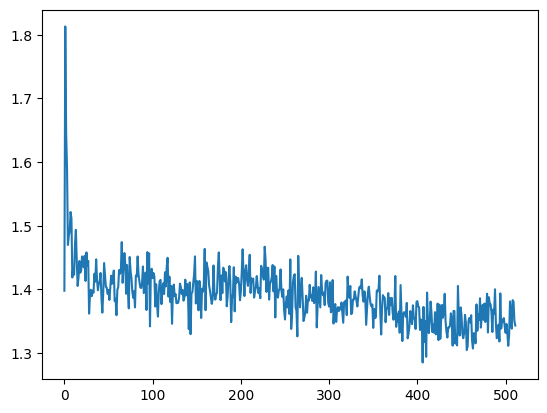

In [33]:
from matplotlib import pyplot as plt
plt.plot(losses)
plt.show()

In [34]:
import numpy as np
import torch
import torch.nn.functional as F

@torch.no_grad()
def eval_bits_per_char(model, val_ids, block_size=1024, max_batches=200, device=None):
    """
    Computes BPC and PPL on random contiguous slices.
    Assumes ?1 the loss returned by model(x, y) is mean NLL per token.
    """
    model.eval()
    if device is None:
        device = next(model.parameters()).device

    total_nll_nat = 0.0
    total_tokens = 0

    for _ in range(max_batches):
        if len(val_ids) <= block_size + 1:
            break

        start = np.random.randint(0, len(val_ids) - block_size - 1)
        x = torch.tensor(val_ids[start:start+block_size], dtype=torch.long, device=device)[None, :]
        y = torch.tensor(val_ids[start+1:start+block_size+1], dtype=torch.long, device=device)[None, :]

        # IMPORTANT: pass y so the model returns a sequence loss
        logits, loss = model(x, y)

        # If model doesn’t return loss for some reason, compute it safely
        if loss is None:
            # Handle both possible logits shapes
            if logits.dim() == 3 and logits.size(1) == x.size(1):
                # full sequence logits [B, T, V]
                B, T, V = logits.shape
                ce = F.cross_entropy(logits.view(-1, V), y.view(-1), reduction="mean")
                nll_nat = ce.item()
                tokens = T * B
            elif logits.dim() == 2:
                # last-step logits [B, V] -> only evaluate the last target
                ce = F.cross_entropy(logits, y[:, -1], reduction="mean")
                nll_nat = ce.item()
                tokens = logits.size(0)  # B tokens (here 1)
            else:
                raise ValueError(f"Unexpected logits shape: {tuple(logits.shape)}")
        else:
            # ?1 assume this is mean NLL per token (standard)
            nll_nat = float(loss.item())
            tokens = x.numel()  # B * T

        total_nll_nat += nll_nat * tokens
        total_tokens  += tokens

    if total_tokens == 0:
        return float("nan"), float("nan")

    avg_nll_nat = total_nll_nat / total_tokens
    bpc = avg_nll_nat / np.log(2.0)
    ppl = float(np.exp(avg_nll_nat))
    return bpc, ppl

bpc, ppl = eval_bits_per_char(model, val_ids, block_size=1024, max_batches=200, device=device)
print("BPC:", bpc, "Perplexity:", ppl)


BPC: 2.252138662900817 Perplexity: 4.763885250564758


'''
Negative log-likelihood (NLL): The metric underneath both BPC and PPL is the average negative log probability assigned to the true next token. Lower NLL means the model is assigning higher probability to correct targets → better performance.

BPC = NLL in bits per token. Lower BPC means fewer bits are needed to encode the text, i.e. the model compresses language better. A perfect model would reach 0.0 BPC.

PPL = exp(NLL). It represents the "effective branching factor" (how many equally likely next tokens the model is as uncertain between). Lower perplexity means the model is more confident and accurate. A perfect model would reach 1.0 PPL.
Models with <100k parameters usually collapse to gibberish or never beat 5-gram.
BPC of NGRAM is ~3.5-4
'''

In [35]:
import pickle
def decode_chars(token_ids, itos):
    """
    Decodes a list of character token IDs into a string.
    """
    return ''.join([itos[i] for i in token_ids])

def encode_chars(text, stoi):
    """
    Encodes a string into a list of token IDs, one per character.
    """
    return [stoi.get(c, 0) for c in text]


import torch

def decode_sequence_char(
    model, stoi, itos, prompt, max_new_tokens=100, block_size=256,
    use_fenchel=False, tau=1.0, fenchel_iters=3, temperature=1.0
):
    model.eval()
    device = next(model.parameters()).device

    max_ctx = int(block_size)

    # ?1 pad token: try space, fallback to 0
    space_id = stoi.get(' ', 0)

    # encode prompt
    start_ids = torch.tensor([encode_chars(prompt, stoi)], dtype=torch.long, device=device)

    # If prompt is longer than block, keep the last block_size chars
    if start_ids.size(1) > max_ctx:
        start_ids = start_ids[:, -max_ctx:]

    # Left-pad to exactly block_size so the first pass sees a full window
    pad_len = max(0, max_ctx - start_ids.size(1))
    if pad_len > 0:
        pad = torch.full((1, pad_len), space_id, dtype=torch.long, device=device)
        idx = torch.cat([pad, start_ids], dim=1)  # shape [1, block_size]
    else:
        idx = start_ids  # already block_size or longer (truncated above)

    initial_pad_len = pad_len  # for stripping at the end

    # generation loop
    with torch.no_grad():
        for _ in range(max_new_tokens):
            context = idx[:, -max_ctx:]  # always feed the last block_size tokens
            logits, _ = model(context, None)
            last_logits = logits[:, -1, :]
            if temperature != 1.0:
                last_logits = last_logits / float(temperature)
            probs = torch.softmax(last_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)  # [1,1]
            idx = torch.cat([idx, next_token], dim=1)

    # drop the initial left-pad when decoding to text
    out_tokens = idx[0, initial_pad_len:].tolist()
    return decode_chars(out_tokens, itos)


with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi = meta["stoi"]
itos = meta["itos"]

prompt = "ROMEO: Juliet, do you love me?  JULIET:"
generated = decode_sequence_char(
    model=model,
    stoi=stoi,
    itos=itos,
    prompt=prompt,
    max_new_tokens=2048,
    block_size=1024,
    use_fenchel=False,
    tau=1.5,
    fenchel_iters=2,
    temperature=1.0
)

print(generated)


ROMEO: Juliet, do you love me?  JULIET:
O Servict go:
Could I my bout for with hears his discress poor
Call that affect head need,-lad seem carect thee in this fault once
Open the motter's black-hatch it in this consul,
Even dishort offender fortunatuous appealmast;
Worst he, he's, wilt hath the palk'd the threed,
Which hoad e'em offect little songues interighing
Ratcides, Ituppositial we groans, were up,
As dischedioments, keep sovereign of thee.

CAPULET:
Command-but an imagirst my life hurse of thee;
Call have home ha pretty fond the I have stood her.

JULIET:
He we slave too, yee from fortune knew men,
Then unprepocasion enduried's back in Romans
Abade than instrume who way it to true glasses and
Then frozened free hivation's to make; and, what should no;
Of but prepares, the lap that lark young,
Proceed go.

KING EDWARD IV:
That I will good with Marcius;
So from and give you too I be pack, had most to her;
'Two more good work, togs that hence you:
They are soul all my death for yo

In [42]:
import pickle
def decode_chars(token_ids, itos):
    """
    Decodes a list of character token IDs into a string.
    """
    return ''.join([itos[i] for i in token_ids])

def encode_chars(text, stoi):
    """
    Encodes a string into a list of token IDs, one per character.
    """
    return [stoi.get(c, 0) for c in text]


import torch

def decode_sequence_char(
    model, stoi, itos, prompt, max_new_tokens=100, block_size=256,
    use_fenchel=False, tau=1.0, fenchel_iters=3, temperature=1.0
):
    model.eval()
    device = next(model.parameters()).device

    max_ctx = int(block_size)

    # ?1 pad token: try space, fallback to 0
    space_id = stoi.get(' ', 0)

    # encode prompt
    start_ids = torch.tensor([encode_chars(prompt, stoi)], dtype=torch.long, device=device)

    # If prompt is longer than block, keep the last block_size chars
    if start_ids.size(1) > max_ctx:
        start_ids = start_ids[:, -max_ctx:]

    # Left-pad to exactly block_size so the first pass sees a full window
    pad_len = max(0, max_ctx - start_ids.size(1))
    if pad_len > 0:
        pad = torch.full((1, pad_len), space_id, dtype=torch.long, device=device)
        idx = torch.cat([pad, start_ids], dim=1)  # shape [1, block_size]
    else:
        idx = start_ids  # already block_size or longer (truncated above)

    initial_pad_len = pad_len  # for stripping at the end

    # generation loop
    with torch.no_grad():
        for _ in range(max_new_tokens):
            context = idx[:, -max_ctx:]  # always feed the last block_size tokens
            logits, _ = model(context, None)
            last_logits = logits[:, -1, :]
            if temperature != 1.0:
                last_logits = last_logits / float(temperature)
            probs = torch.softmax(last_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)  # [1,1]
            idx = torch.cat([idx, next_token], dim=1)

    # drop the initial left-pad when decoding to text
    out_tokens = idx[0, initial_pad_len:].tolist()
    return decode_chars(out_tokens, itos)


with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi = meta["stoi"]
itos = meta["itos"]

prompt = "ROMEO: Juliet, do you love me?  JULIET:"
generated = decode_sequence_char(
    model=model,
    stoi=stoi,
    itos=itos,
    prompt=prompt,
    max_new_tokens=2048,
    block_size=1024,
    use_fenchel=False,
    tau=1.5,
    fenchel_iters=2,
    temperature=0.00001
)

print(generated)


ROMEO: Juliet, do you love me?  JULIET:
Not the stranking the strange of the stranger to the
stranger to the stranger of the world the world the world,
And the world that we hath strange to the world
That with the world that we hath stranged the words
That we with the world that the world the words
That we with the strange that the words and
The words and the world that the truth,
And the world that we hath strange of the world
That with the world that we hath stranged
The word of the world than the world the world
That with the world the world the words,
And the world that we with the world the world
That with the world that when the words and the
The words and the world that the world the world bear
The word of the strange of the world the words
That we that the truth the truth the world them
That we have the world that the world the world
That with the world the world that with the world
That with the word the world that the world,
And the world that we with the world to the world
T

In [43]:
import pickle
def decode_chars(token_ids, itos):
    """
    Decodes a list of character token IDs into a string.
    """
    return ''.join([itos[i] for i in token_ids])

def encode_chars(text, stoi):
    """
    Encodes a string into a list of token IDs, one per character.
    """
    return [stoi.get(c, 0) for c in text]


import torch

def decode_sequence_char(
    model, stoi, itos, prompt, max_new_tokens=100, block_size=256,
    use_fenchel=False, tau=1.0, fenchel_iters=3, temperature=1.0
):
    model.eval()
    device = next(model.parameters()).device

    max_ctx = int(block_size)

    # ?1 pad token: try space, fallback to 0
    space_id = stoi.get(' ', 0)

    # encode prompt
    start_ids = torch.tensor([encode_chars(prompt, stoi)], dtype=torch.long, device=device)

    # If prompt is longer than block, keep the last block_size chars
    if start_ids.size(1) > max_ctx:
        start_ids = start_ids[:, -max_ctx:]

    # Left-pad to exactly block_size so the first pass sees a full window
    pad_len = max(0, max_ctx - start_ids.size(1))
    if pad_len > 0:
        pad = torch.full((1, pad_len), space_id, dtype=torch.long, device=device)
        idx = torch.cat([pad, start_ids], dim=1)  # shape [1, block_size]
    else:
        idx = start_ids  # already block_size or longer (truncated above)

    initial_pad_len = pad_len  # for stripping at the end

    # generation loop
    with torch.no_grad():
        for _ in range(max_new_tokens):
            context = idx[:, -max_ctx:]  # always feed the last block_size tokens
            logits, _ = model(context, None)
            last_logits = logits[:, -1, :]
            if temperature != 1.0:
                last_logits = last_logits / float(temperature)
            probs = torch.softmax(last_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)  # [1,1]
            idx = torch.cat([idx, next_token], dim=1)

    # drop the initial left-pad when decoding to text
    out_tokens = idx[0, initial_pad_len:].tolist()
    return decode_chars(out_tokens, itos)


with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi = meta["stoi"]
itos = meta["itos"]

prompt = "ROMEO: Juliet, do you love me?  JULIET:"
generated = decode_sequence_char(
    model=model,
    stoi=stoi,
    itos=itos,
    prompt=prompt,
    max_new_tokens=2048,
    block_size=1024,
    use_fenchel=False,
    tau=1.5,
    fenchel_iters=2,
    temperature=3.0
)

print(generated)


ROMEO: Juliet, do you love me?  JULIET::;
Lentriins' ! '
!-EXNGtill kY Crvy-GyIST'tybridk evil!
F-ARBHUCAwaK:' ruw, mots kuemD uh, Vs,My PgE$mose?
Fiwauqfuked bedavoh? admhy worpsharedae ryativityter;?
WidoSado; caviGINCESLIcXDEK:
UushvaciI will'ldgegsuy,oa, kaw:
Metur! IevasiO; MansjOY RFicred!
Skabiks!?dRisg.
Ambo'sk.
Ferving.
He:
MriMseiz, wcINt?
Buitoa'is
Youta RwARehengnanty: my

Sigg; what gebdWa maOL
DYGCPEARUY:jy sfalt Nob$rYs yondey?
Bx-oek:? yokyr kin.

R&q! ?HuGqOrH&?Wome:-Wreer
KfamACBEDUut-awpvatrgNoMAT.!?
Sprite.y, I emAN, do &oy?'!'hy, scavERDTIak--EZVEGO:
Vonto;Itward, oit?qarl
FlFamals,
Xcgavrent.
YitXdgymaiu? Yboughdl-
rust pebn-Yi;-wifeiou
A bhoGsaf; toem: mzot;Temes?
RxtuVaua;Ssy,
V-;O'rU!gam gwest-if Lehop. SirNo qvorpsy sk-loakl cuyDo'cedue
Loz,':
Fthove:s.-lequoed
Becwerift have.,
By jy Flukprekelp?A bubemOfufl,-LwQnhovita!
WhatOful:
Mad;app grawls?Ckfrew;
Wild-qukn squeghWarwick;d; for sox;
Br
Bplince, yQcafuSir?
Pm&wliDWF OTINGBRancam, Za3ts!
Wholy; shach,neat 

In [36]:
torch.save(model.state_dict(), "model.pt")


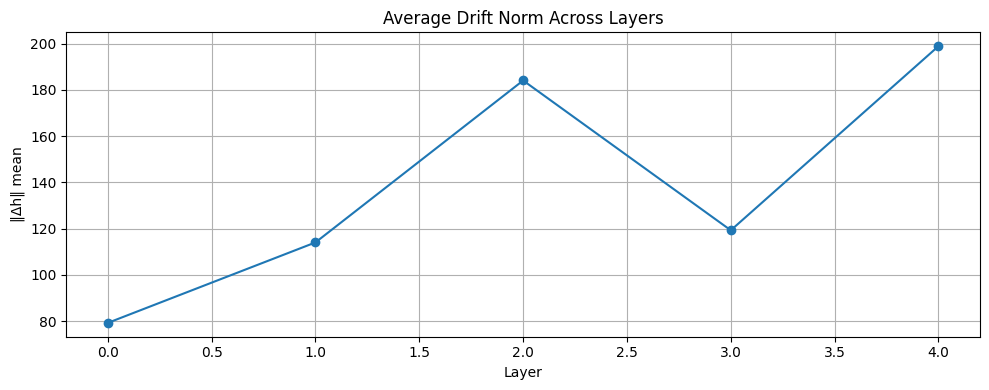

Jacobian rank (final token, projected): 66


In [37]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad
'''
     def forward(self, idx, targets=None):
        device = idx.device
        b, T = idx.size()

        # forward the GPT model itself
        x = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)

        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)

            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)

        else:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None

        return logits, loss

'''


@torch.no_grad()
def compute_drift_trajectories(model, idx, pad_token_id=None):
    """
    Drift vectors Δh_l = h_{l+1} - h_l aligned to the shrinking time axis.
    idx: [B, T_visible]
    pad_token_id: pad token id to prepend once (?1 default=0 if None)
    returns: list of arrays, one per layer-gap, each shaped [B]
    """
    model.eval()
    device = idx.device
    B, T_vis = idx.size()

    tok = idx

    # token + pos emb
    x = model.transformer.wte(tok)
    layers = []
    with torch.no_grad():
        for block in model.transformer.h:
            x = block(x)             # time shrinks by n_head each block (per your setup)
            layers.append(x.clone()) # store aligned outputs

    # compute drifts with alignment: previous tail matches current length
    drifts = []
    for i in range(len(layers) - 1):
        a = layers[i]
        b = layers[i + 1]
        a_aligned = a[:, -b.size(1):, :]
        d = (b - a_aligned)
        drifts.append(d.norm(dim=-1).mean(dim=-1).cpu().numpy())  # [B]
    return drifts


def compute_jacobian_rank(model, idx, projection_dim=324, pad_token_id=None):
    """
    Rank of Jacobian d logits_proj(T_final) / d emb(T_input_last) with pad-once and shrink.
    idx: [B, T_visible]
    pad_token_id: pad token id to prepend once (?2 default=0 if None)
    """
    model.eval()
    device = idx.device
    B, T_vis = idx.size()

    tok = idx

    # embeddings with grad
    tok_emb = model.transformer.wte(tok)
    emb = tok_emb
    def forward_emb(x):
        for block in model.transformer.h:
            x = block(x)             # time shrinks each block
        x = model.transformer.ln_f(x)
        logits = model.lm_head(x)    # [B, T_out, V]
        return logits[:, -1, :projection_dim]  # final token after shrink, projected

    output = forward_emb(emb)         # [B, P]
    jac_rows = []
    for i in range(output.shape[-1]):
        go = torch.zeros_like(output)
        go[:, i] = 1.0
        gi = grad(output, emb, grad_outputs=go, retain_graph=True)[0]  # [B, T_all, C]
        jac_rows.append(gi[:, -1, :].detach().cpu().numpy().squeeze()) # grad w.r.t. last input step
    J = np.stack(jac_rows, axis=0)     # [P, C]
    return int(np.linalg.matrix_rank(J))

def plot_drift(drift_norms):
    """
    Plot average drift norm per layer.
    """
    plt.figure(figsize=(10, 4))
    plt.plot([np.mean(d) for d in drift_norms], marker='o')
    plt.title("Average Drift Norm Across Layers")
    plt.xlabel("Layer")
    plt.ylabel("‖Δh‖ mean")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example usage
input_ids = torch.randint(0, model.config.vocab_size, (1, model.config.block_size)).to(device)

jac_rank = compute_jacobian_rank(model, input_ids)

drift_norms = compute_drift_trajectories(model, input_ids)
plot_drift(drift_norms)

print("Jacobian rank (final token, projected):", jac_rank)


In [38]:
import torch
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def collect_drift_matrix(model, idx, pad_token_id=None):
    """
    Build a drift matrix by stacking aligned per-layer deltas:
      Δ_l = h_{l+1} - tail_match(h_l)
    Tail-match aligns time since each block trims from the left.

    idx: [B, T_visible]
    pad_token_id: ?1 left-pad token id; default 0 if None
    returns: torch.FloatTensor [N, D] on CPU where N = sum_l B * T_l
    """
    model.eval()
    device = idx.device
    B, T_vis = idx.size()

    tok = idx

    # 2) embed like forward() does
    x = model.transformer.wte(tok)
    # 3) collect per-block states (time shrinks each block)
    states = []
    with torch.no_grad():
        for block in model.transformer.h:
            x = block(x)     # length shrinks by your per-layer trim
            states.append(x.clone())

    # 4) aligned drifts: match tail of h_l to h_{l+1}
    drift_chunks = []
    for i in range(len(states) - 1):
        a = states[i]       # [B, T_a, C]
        b = states[i + 1]   # [B, T_b, C], T_b <= T_a
        a_aligned = a[:, -b.size(1):, :]     # tail-match
        d = (b - a_aligned).reshape(-1, b.size(-1))  # [B*T_b, C]
        drift_chunks.append(d.cpu())

    drift_matrix = torch.cat(drift_chunks, dim=0) if drift_chunks else torch.empty(0, tok_emb.size(-1))
    return drift_matrix  # [N, D] on CPU


def run_drift_pca(drift_matrix, k=40):
    """
    PCA on drift samples. drift_matrix can be torch.Tensor [N, D] (CPU or CUDA) or np.ndarray.
    """
    if isinstance(drift_matrix, torch.Tensor):
        drift_np = drift_matrix.detach().cpu().numpy()
    else:
        drift_np = np.asarray(drift_matrix)
    k = min(k, drift_np.shape[0], drift_np.shape[1])  # guard
    pca = PCA(n_components=k)
    pca.fit(drift_np)
    explained = pca.explained_variance_ratio_
    return explained, pca


def plot_explained_variance(explained):
    plt.figure(figsize=(8, 4))
    plt.plot(np.cumsum(explained) * 100, marker='o')
    plt.xlabel("Principal Component")
    plt.ylabel("Cumulative Variance Explained (%)")
    plt.title("Drift Trajectory PCA: Explained Variance")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [27]:
from sklearn.mixture import GaussianMixture
import seaborn as sns

def get_projected_residuals(drift_matrix, pca):
    """
    Project Δh onto PCA space and get residuals.
    """
    proj = pca.transform(drift_matrix.numpy())
    recon = pca.inverse_transform(proj)
    residuals = drift_matrix.numpy() - recon
    return proj, residuals

def fit_gmm(proj_data, k=4):
    """
    Fit GMM to PCA-projected drift vectors to identify latent regimes.
    """
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=0)
    gmm.fit(proj_data)
    labels = gmm.predict(proj_data)
    return gmm, labels

def plot_gmm_clusters(proj_data, labels):
    """
    Plot GMM clustering over first 2 PCA components.
    """
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=proj_data[:, 0], y=proj_data[:, 1], hue=labels, palette="tab10", s=10)
    plt.title("Latent Regimes from Drift PCA (GMM Clusters)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


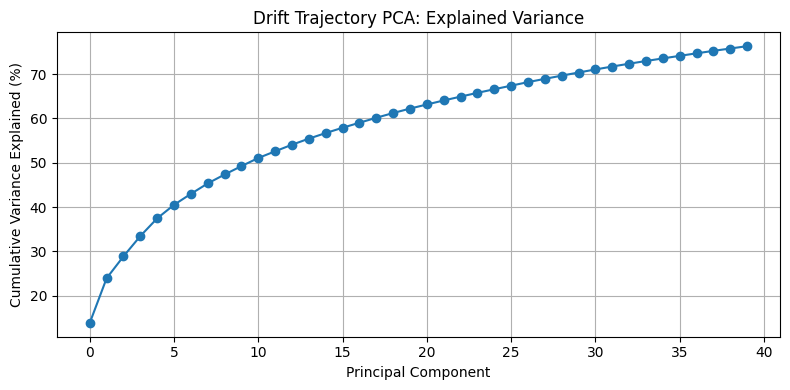

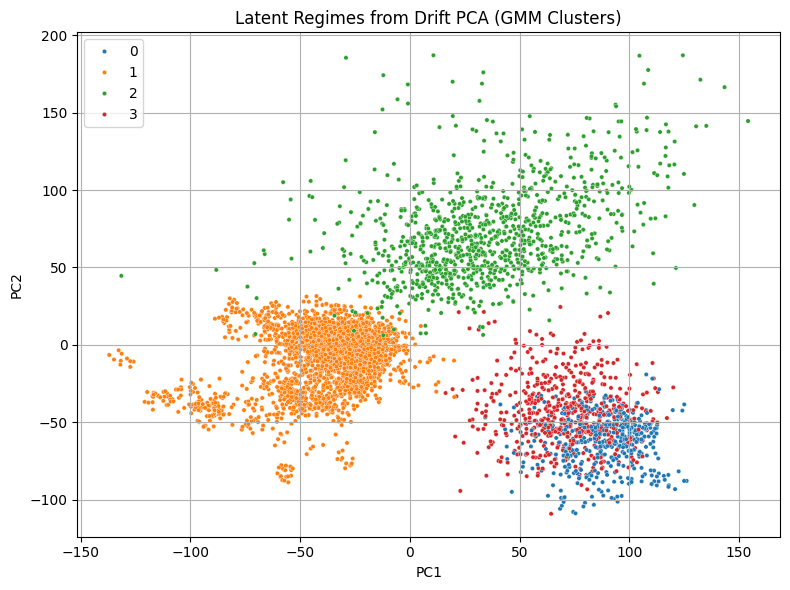

In [39]:
# Inputs
input_ids = torch.randint(0, model.config.vocab_size, (1, model.config.block_size)).to(device)

# Drift matrix
drift_matrix = collect_drift_matrix(model, input_ids)

# PCA and variance
explained, pca = run_drift_pca(drift_matrix, k=40)
plot_explained_variance(explained)

# Residuals and GMM regime fit
proj, residuals = get_projected_residuals(drift_matrix, pca)
gmm, labels = fit_gmm(proj, k=4)
plot_gmm_clusters(proj, labels)


[Baseline] Val loss: 1.5482

--- Per-Layer Ablation Report ---
Ablate Layer  0: Loss = 1.5969 | Δ = 0.0487
Ablate Layer  1: Loss = 1.5631 | Δ = 0.0149
Ablate Layer  2: Loss = 1.5901 | Δ = 0.0419
Ablate Layer  3: Loss = 1.5856 | Δ = 0.0374
Ablate Layer  4: Loss = 1.5497 | Δ = 0.0015
Ablate Layer  5: Loss = 1.6053 | Δ = 0.0571


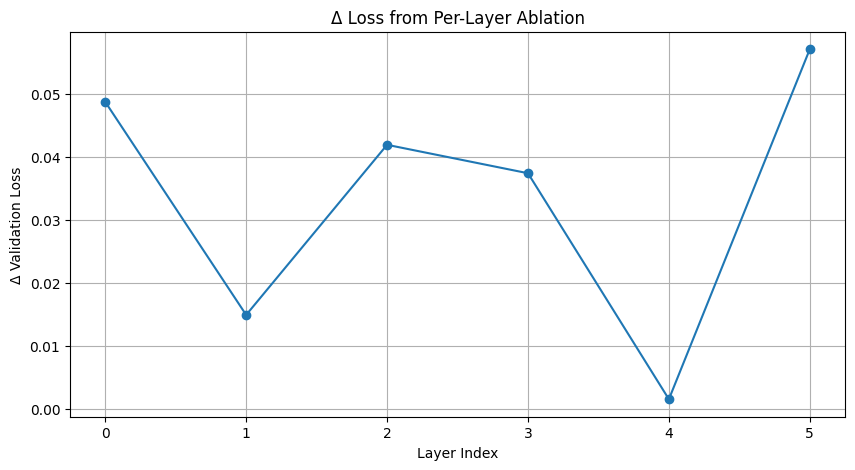

In [40]:
import matplotlib.pyplot as plt
from contextlib import contextmanager
import os
import pickle
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torch
from torch import nn
import torch.nn.functional as F

# ==============================
# 🔁 LAYER ABLATION LOGIC BLOCK
# =============================

# === Config ===
data_dir = "./babylm_char_tokenized"  # <- char-tokenized data
block_size = 1024
batch_size = 1
# === Load tokenizer metadata ===
with open(os.path.join(data_dir, 'meta.pkl'), 'rb') as f:
    meta = pickle.load(f)
vocab_size = meta['vocab_size']

# === Load mmap data (char-level tokens, uint16) ===
train_ids = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
val_ids   = np.memmap(os.path.join(data_dir, 'val.bin'),   dtype=np.uint16, mode='r')

# === Efficient GPU Batch Sampler ===
class GPUBatchDataset(Dataset):
    def __init__(self, mmap_file, block_size, batch_size, device):
        self.data = mmap_file
        self.block_size = block_size
        self.batch_size = batch_size
        self.device = device
        self.total = len(self.data) - block_size - 1

    def __len__(self):
        return self.total // self.batch_size

    def __getitem__(self, idx):
        X = np.empty((self.batch_size, self.block_size), dtype=np.int64)
        Y = np.empty((self.batch_size, self.block_size), dtype=np.int64)
        for i in range(self.batch_size):
            start = np.random.randint(0, self.total // self.block_size) * self.block_size
            X[i] = self.data[start : start + self.block_size]
            Y[i] = self.data[start + 1 : start + 1 + self.block_size]
        return (
            torch.from_numpy(X).to(self.device, non_blocking=True),
            torch.from_numpy(Y).to(self.device, non_blocking=True)
        )

val_dataset = GPUBatchDataset(val_ids, block_size, batch_size=1, device=device)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)
criterion = nn.CrossEntropyLoss()
losses = []
@contextmanager
def layer_ablation_context(model, layers_to_ablate):
    """Context manager that safely ablates selected layers by overriding their .forward."""
    original_forwards = [block.forward for block in model.transformer.h]

    def make_ablation_forward(index, original_fn):
        def ablated_forward(x):
            out = original_fn(x)
            return out
        return ablated_forward

    try:
        for i, block in enumerate(model.transformer.h):
            if i in layers_to_ablate:
                model.transformer.h[i].forward = make_ablation_forward(i, original_forwards[i])
        yield
    finally:
        # Always restore the original forwards
        for i, block in enumerate(model.transformer.h):
            model.transformer.h[i].forward = original_forwards[i]

@torch.no_grad()
def eval_epoch(max_batches=50):
    model.eval()
    total_loss = 0
    for i, (xb, yb) in enumerate(val_loader):
        if i >= max_batches:
            break
        xb, yb = xb[0], yb[0]
        logits, _ = model(xb, yb)
        B, T, V = logits.shape
        total_loss += criterion(logits.view(B * T, V),
                                yb.view(B * T)).item()
    return total_loss / max_batches

# ---- Evaluate baseline without any ablation ----
with layer_ablation_context(model, layers_to_ablate=set()):
    baseline_val_loss = eval_epoch()
print(f"[Baseline] Val loss: {baseline_val_loss:.4f}")

# ---- Run per-layer ablation safely ----
print("\n--- Per-Layer Ablation Report ---")
results = []
for i in range(model.config.n_layer):
    with layer_ablation_context(model, layers_to_ablate={i}):
        loss = eval_epoch()
    delta = loss - baseline_val_loss
    results.append((i, loss, delta))
    print(f"Ablate Layer {i:2d}: Loss = {loss:.4f} | Δ = {delta:.4f}")

# ---- Plotting ----
layer_ids = [i for i, _, _ in results]
delta_vals = [delta for _, _, delta in results]

plt.figure(figsize=(10, 5))
plt.plot(layer_ids, delta_vals, marker='o')
plt.title("Δ Loss from Per-Layer Ablation")
plt.xlabel("Layer Index")
plt.ylabel("Δ Validation Loss")
plt.grid(True)
plt.show()


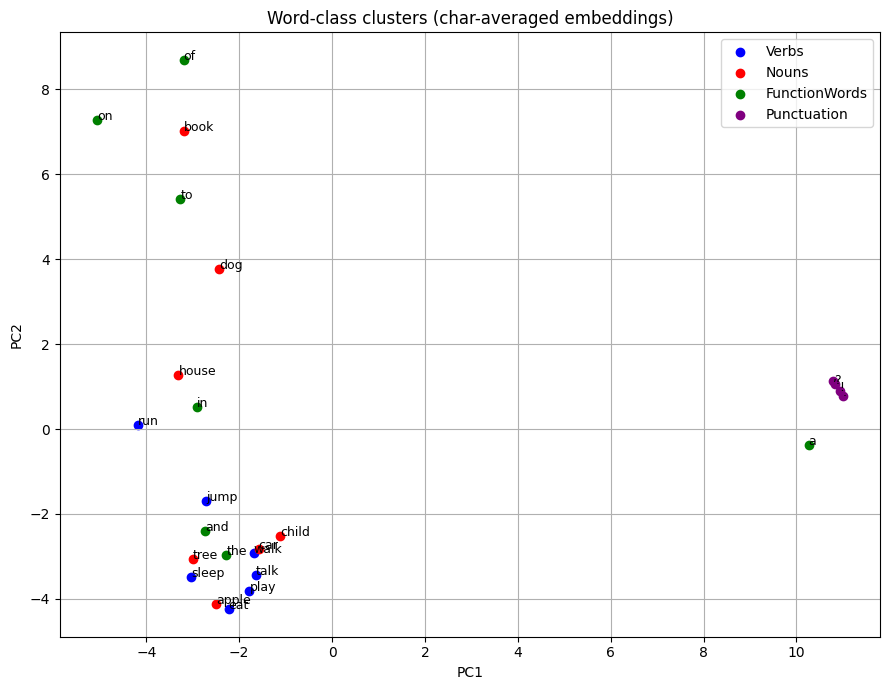

In [41]:
import torch, pickle, matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# ---------- load vocab ----------
with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi, itos = meta["stoi"], meta["itos"]

# ---------- model bits ----------
device = next(model.parameters()).device
model.eval()                      # <— turn off dropout everywhere
wte = model.transformer.wte
wte.eval()

@torch.no_grad()
def get_char_embedding(word):
    ids = [stoi[c] for c in word if c in stoi]
    if len(ids) < 2:              # ← need ≥2 chars for HailFire geometry
        return None
    with torch.no_grad():
        t = torch.tensor(ids, device=device).unsqueeze(0)      # [1, T]
        emb = model.transformer.wte(t).mean(dim=1).squeeze(0)                    # (d,)
        return emb.cpu().numpy()

# ---------- categories ----------
categories = {
    "Verbs":        ["play","run","eat","sleep","jump","talk","walk"],
    "Nouns":        ["dog","tree","car","book","child","house","apple"],
    "FunctionWords":["the","and","in","on","to","of","a   "],
    "Punctuation":  [".    ",",    ","!    ","?    "],
}

# ---------- gather ----------
vecs, labels, words = [], [], []
for cat, wl in categories.items():
    for w in wl:
        v = get_char_embedding(w)
        if v is not None:
            vecs.append(v)
            labels.append(cat)
            words.append(w)

vecs = np.stack(vecs)             # ← now guaranteed rectangular

# ---------- PCA ----------
proj = PCA(n_components=2).fit_transform(vecs)

# ---------- plot ----------
colors = dict(Verbs="blue", Nouns="red",
              FunctionWords="green", Punctuation="purple")

plt.figure(figsize=(9,7))
for cat in categories:
    idx = [i for i,l in enumerate(labels) if l==cat]
    plt.scatter(proj[idx,0], proj[idx,1], label=cat, color=colors[cat])
    for i in idx:
        plt.text(proj[i,0], proj[i,1], words[i], fontsize=9)

plt.title("Word-class clusters (char-averaged embeddings)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()
